# Goal

Identify overwatch heroes in team composition screen. Since the input is an image it could read from videos from youtube or twitch.


# Methodology 

Since I don't really know much of opencv I'll be exploring different functions until I hit something that might work. 

In [1]:
%matplotlib inline

In [2]:
path = 'screenshots/Screenshot from Jayne Reviews - Bronze Ana-jOZ_VdD1-9I.mkv.png'

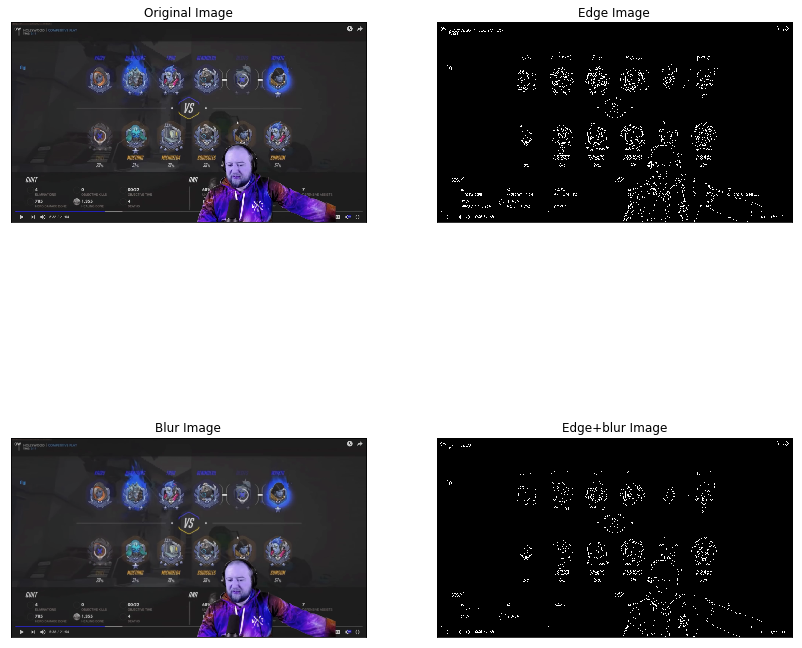

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(path)
edges = cv2.Canny(img,100,200)
blur = cv2.GaussianBlur(img,(5,5),0)
edges2 = cv2.Canny(blur,100,200)

f = plt.figure(figsize=(14,14))
plt.subplot(221),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(blur,cmap = 'gray')
plt.title('Blur Image'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(edges2,cmap = 'gray')
plt.title('Edge+blur Image'), plt.xticks([]), plt.yticks([])

plt.show()

Blur doesn't seem to help much. Edges seems to be ok but may need some processing.

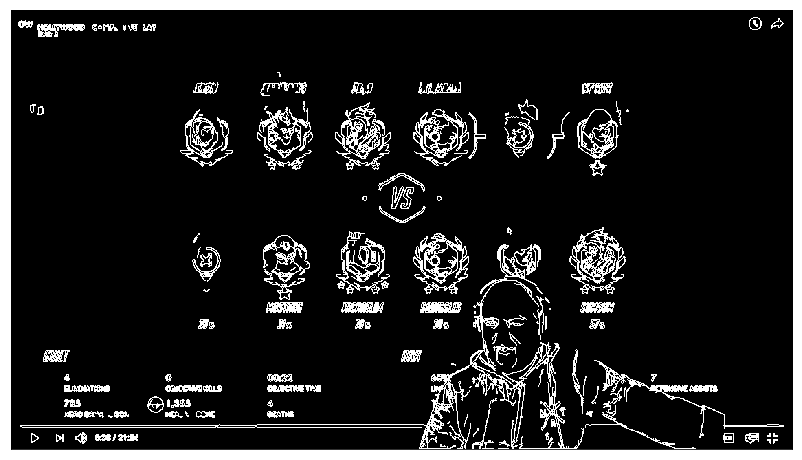

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

edgesDilated = cv2.dilate(edges,kernel,iterations = 1)

f = plt.figure(figsize=(14,14))
plt.subplot(111),plt.imshow(edgesDilated,cmap = 'gray')
plt.xticks([]), plt.yticks([])

plt.show()

Edges look ok I think.

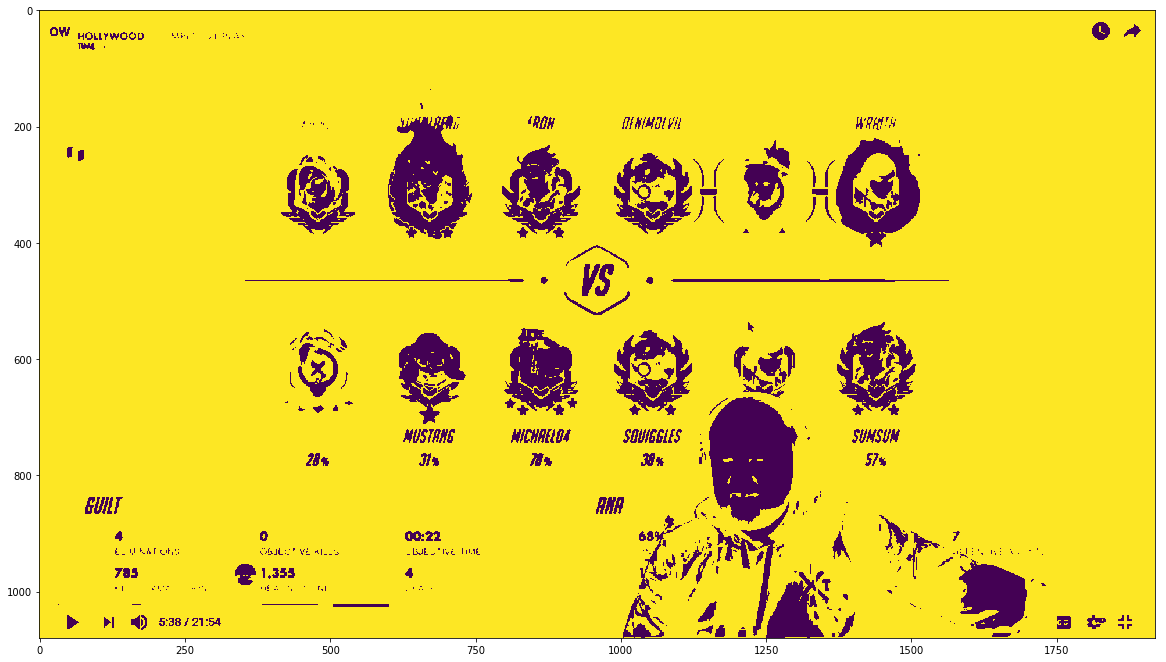

In [5]:
import numpy as np
import cv2

img = cv2.imread(path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh, ret = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

f = plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(ret);

Areas seems to be detected well, but with many false positives as expected. Not sure what to do with this.

525


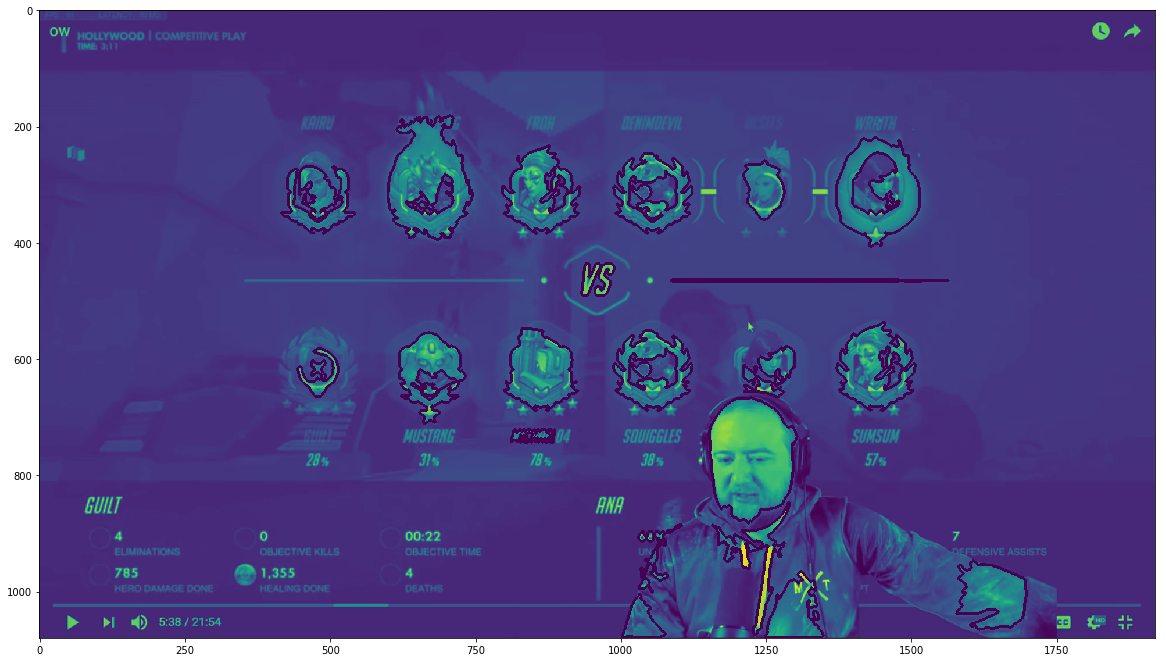

In [6]:
import cv2
import numpy as np

img = cv2.imread(path, 0)
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, thresh= cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im2, contours,hierarchy = cv2.findContours(thresh, 1, 2)

print(len(contours))
for cnt in contours:
    M = cv2.moments(cnt)
    # print(M['m00'])
    if M['m00'] < 1000: continue
    x,y,w,h = cv2.boundingRect(cnt)
    # img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    img = cv2.drawContours(img, [cnt], 0, (0,255,0), 3)

f = plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(img);

Contours seem to be fine. Might be useful.

Let's go back to edges try to match a template.

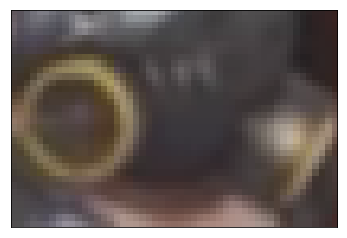

In [7]:
roadhog = cv2.imread('screenshots/roadhog.png')
plt.subplot(111),plt.imshow(cv2.cvtColor(roadhog, cv2.COLOR_BGR2RGB))
plt.title(''), plt.xticks([]), plt.yticks([])
plt.show();

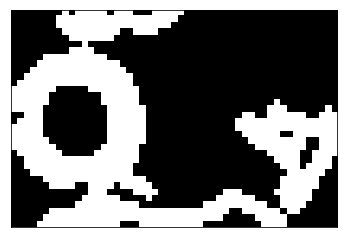

In [8]:
roadhog = cv2.imread('screenshots/roadhog.png')
edges = cv2.Canny(roadhog,100,200)
roadhogEdgesDilated = cv2.dilate(edges,kernel,iterations = 1)


plt.subplot(111),plt.imshow(roadhogEdgesDilated ,cmap = 'gray')
plt.title(''), plt.xticks([]), plt.yticks([])

plt.show()

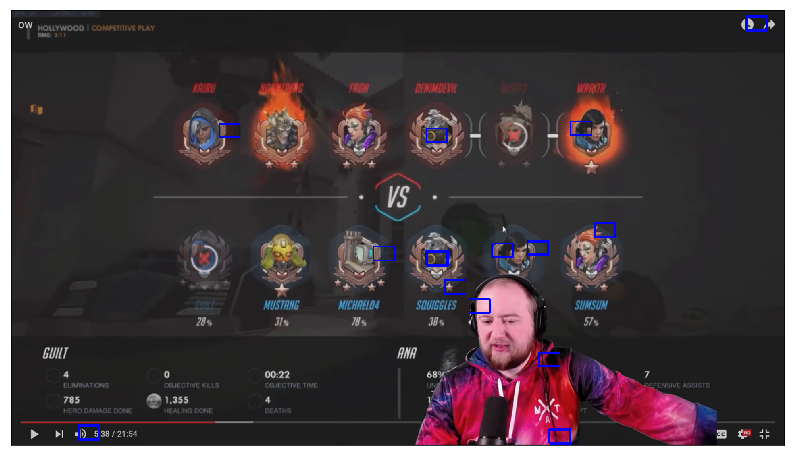

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = edgesDilated
img2 = img.copy()
template = roadhogEdgesDilated
w, h = template.shape[::-1]

img = img2.copy()
method = cv2.TM_SQDIFF# TM_CCOEFF_NORMED

res = cv2.matchTemplate(img,template,method)

img = cv2.imread(path)
result2 = np.reshape(res, res.shape[0]*res.shape[1])
sort = np.argsort(result2)
for i in range(0, 100):
    (y, x) = np.unravel_index(sort[i], res.shape)
    cv2.rectangle(img,(x,y), (x+w,y+h), 255, 2)

f = plt.figure(figsize=(20,8))
plt.subplot(111),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])

plt.show()

I had to run the top 100 results to find both appearances of roadhog, so there are a lot of false positives. Let's try Moira.

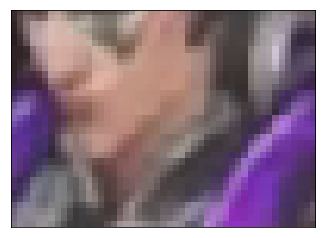

In [10]:
moira = cv2.imread('screenshots/moira.png')
plt.subplot(111),plt.imshow(cv2.cvtColor(moira, cv2.COLOR_BGR2RGB))
plt.title(''), plt.xticks([]), plt.yticks([])
plt.show();

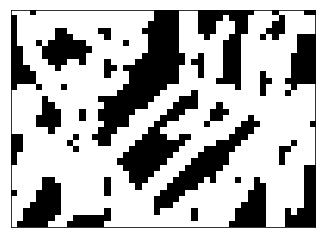

In [11]:
moira = cv2.imread('screenshots/moira.png')
edges = cv2.Canny(moira,100,200)
moiraEdgesDilated = cv2.dilate(edges,kernel,iterations = 1)


plt.subplot(111),plt.imshow(moiraEdgesDilated ,cmap = 'gray')
plt.title(''), plt.xticks([]), plt.yticks([])

plt.show()

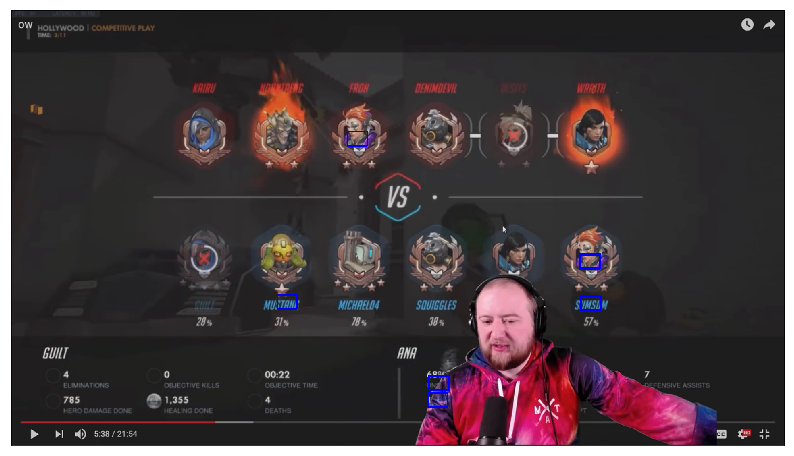

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = edgesDilated
img2 = img.copy()
template = moiraEdgesDilated
w, h = template.shape[::-1]

img = img2.copy()
method = cv2.TM_SQDIFF# TM_CCOEFF_NORMED

res = cv2.matchTemplate(img,template,method)

img = cv2.imread(path)
result2 = np.reshape(res, res.shape[0]*res.shape[1])
sort = np.argsort(result2)
for i in range(0, 20):
    (y, x) = np.unravel_index(sort[i], res.shape)
    cv2.rectangle(img,(x,y), (x+w,y+h), 255, 2)

f = plt.figure(figsize=(20,8))

plt.subplot(111),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

With only 20 results both were detected.

In [13]:
class Rect(object):
    def __init__(self, x, y, w, h):
        self.left = x
        self.right = x + w
        self.top = y
        self.bottom = y + h

    def overlaps(self, r2):
        return (
            min(self.right, r2.right) - max(self.left, r2.left) > 0 and
            min(self.bottom, r2.bottom) - max(self.top, r2.top) > 0
        )

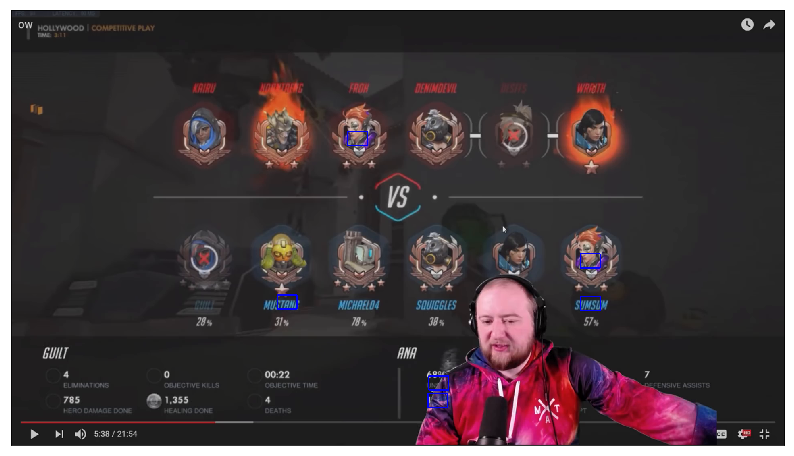

In [14]:
img = edgesDilated
img2 = img.copy()
template = moiraEdgesDilated
w, h = template.shape[::-1]

img = img2.copy()
method = cv2.TM_SQDIFF

res = cv2.matchTemplate(img,template,method)

img = cv2.imread(path)
result2 = np.reshape(res, res.shape[0]*res.shape[1])
sort = np.argsort(result2)
rectangles = []
for i in range(0, 20):
    (y, x) = np.unravel_index(sort[i], res.shape)
    rect = Rect(x, y, w, h)
    dupe = False

    for r in rectangles:
        dupe = rect.overlaps(r)
        if dupe:
            break
    if dupe:
        continue

    rectangles.append(rect)
    cv2.rectangle(img,(x,y), (x+w,y+h), 255, 2)

f = plt.figure(figsize=(20,8))

plt.subplot(111),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

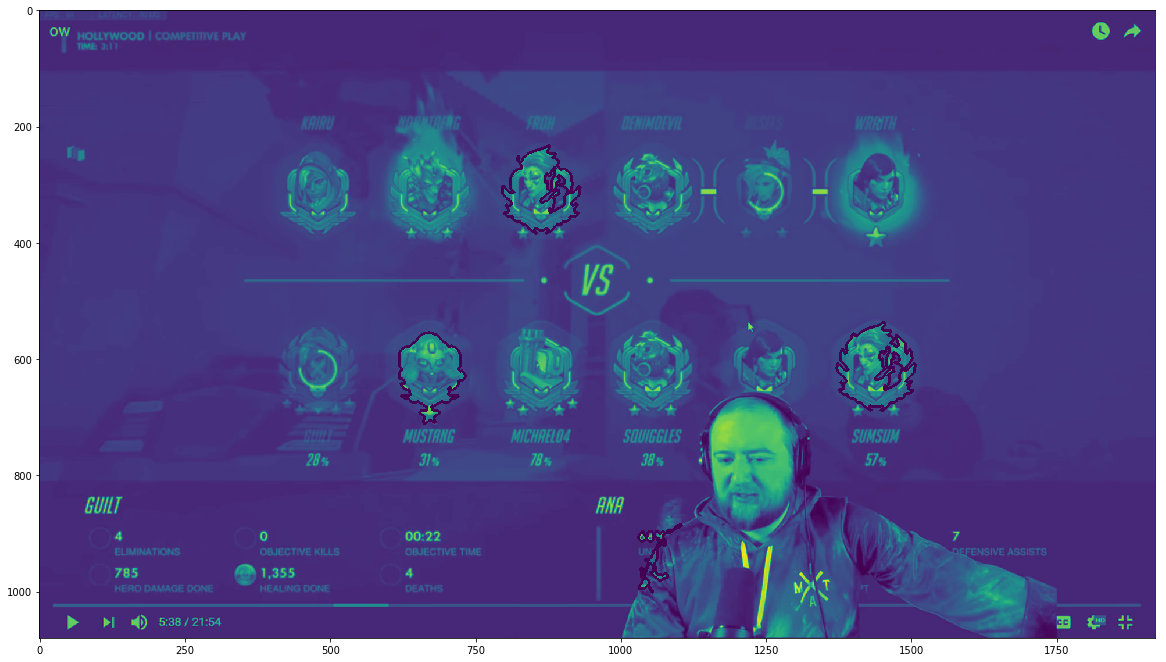

In [15]:
img = cv2.imread(path, 0)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, thresh= cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im2, contours, hierarchy = cv2.findContours(thresh, 1, 2)

for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] < 1000: continue
    rect = Rect(*cv2.boundingRect(cnt))
    for r in rectangles:
        overlaps = rect.overlaps(r)
        if overlaps:
            break

    if not overlaps:
        continue
    img = cv2.drawContours(img, [cnt], 0, (0,255,0), 3)

f = plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(img);

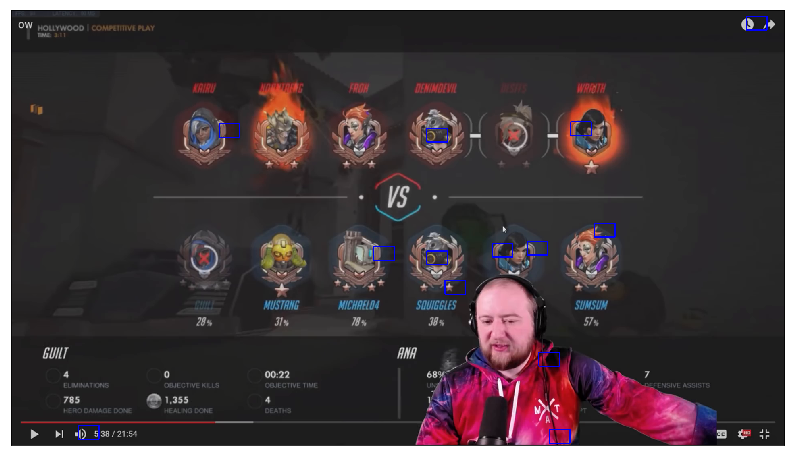

In [16]:
img = edgesDilated
img2 = img.copy()
template = roadhogEdgesDilated
w, h = template.shape[::-1]

img = img2.copy()
method = cv2.TM_SQDIFF

res = cv2.matchTemplate(img,template,method)

img = cv2.imread(path)
result2 = np.reshape(res, res.shape[0]*res.shape[1])
sort = np.argsort(result2)
rectangles = []
for i in range(0, 80):
    (y, x) = np.unravel_index(sort[i], res.shape)
    rect = Rect(x, y, w, h)
    dupe = False

    for r in rectangles:
        dupe = rect.overlaps(r)
        if dupe:
            break
    if dupe:
        continue

    rectangles.append(rect)
    cv2.rectangle(img,(x,y), (x+w,y+h), 255, 2)

f = plt.figure(figsize=(20,8))

plt.subplot(111),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

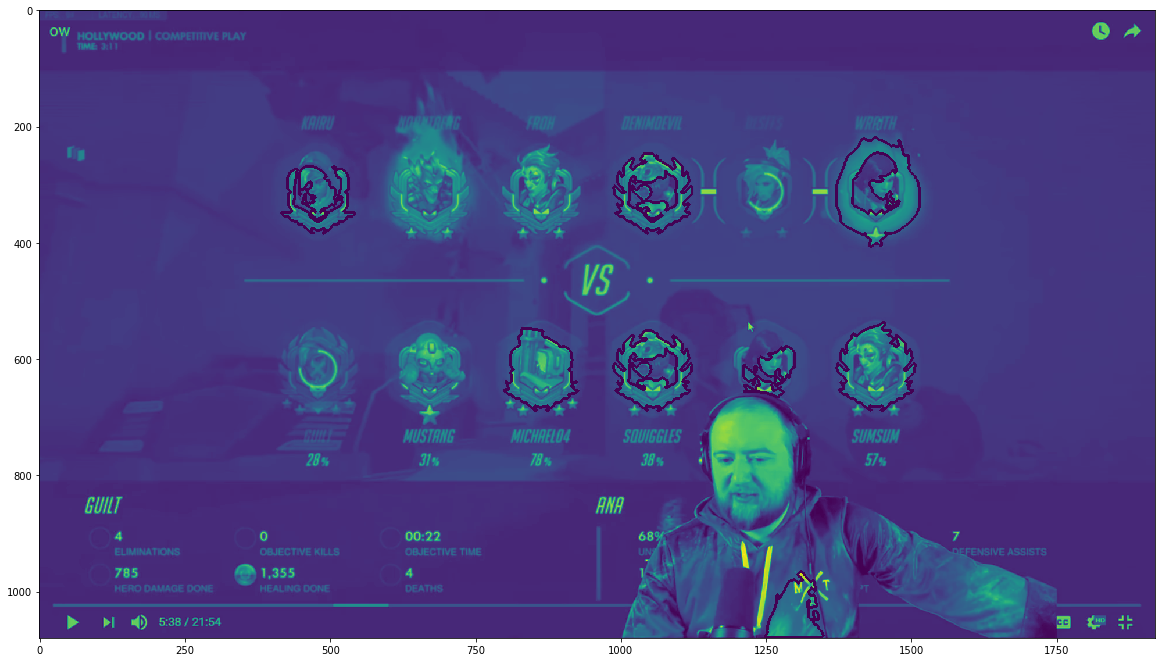

In [17]:
img = cv2.imread(path, 0)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, thresh= cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im2, contours, hierarchy = cv2.findContours(thresh, 1, 2)

for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] < 1000: continue
    rect = Rect(*cv2.boundingRect(cnt))
    for r in rectangles:
        overlaps = rect.overlaps(r)
        if overlaps:
            break

    if not overlaps:
        continue
    img = cv2.drawContours(img, [cnt], 0, (0,255,0), 3)

f = plt.figure(figsize=(20,20))
plt.subplot(111)
plt.imshow(img);

In [18]:
img = cv2.imread(path, 0)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, thresh= cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im2, contours, hierarchy = cv2.findContours(thresh, 1, 2)

moments = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M['m00'] < 1000: continue
    rect = Rect(*cv2.boundingRect(cnt))
    for r in rectangles:
        overlaps = rect.overlaps(r)
        if overlaps:
            break

    if not overlaps:
        continue
    moments.append((M, cnt))

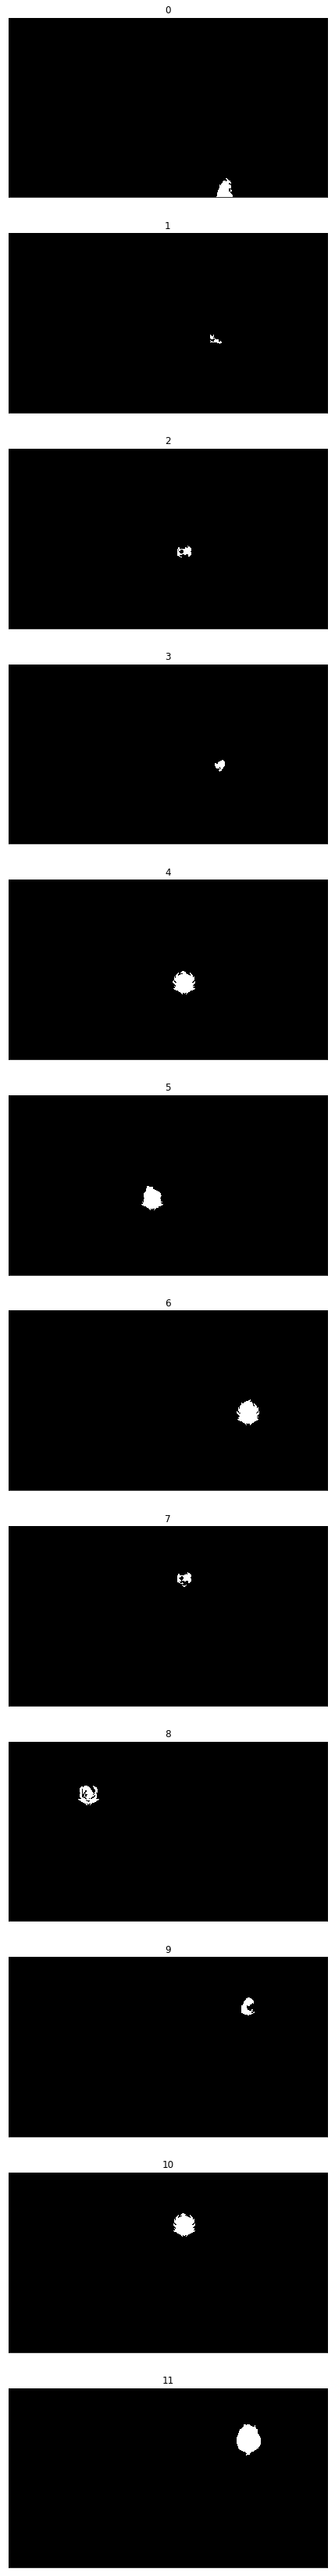

In [19]:
f = plt.figure(figsize=(20, len(moments) * 5))
for i, (M, cnt) in enumerate(moments):
    mask = np.full(img.shape[:2], 0, np.uint8)
    plt.subplot(len(moments), 1, i+1)
    color = ('b','g','r')
    cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
    plt.title(str(i))
    plt.xticks([]), plt.yticks([])
    plt.imshow(mask, 'gray')
plt.show()

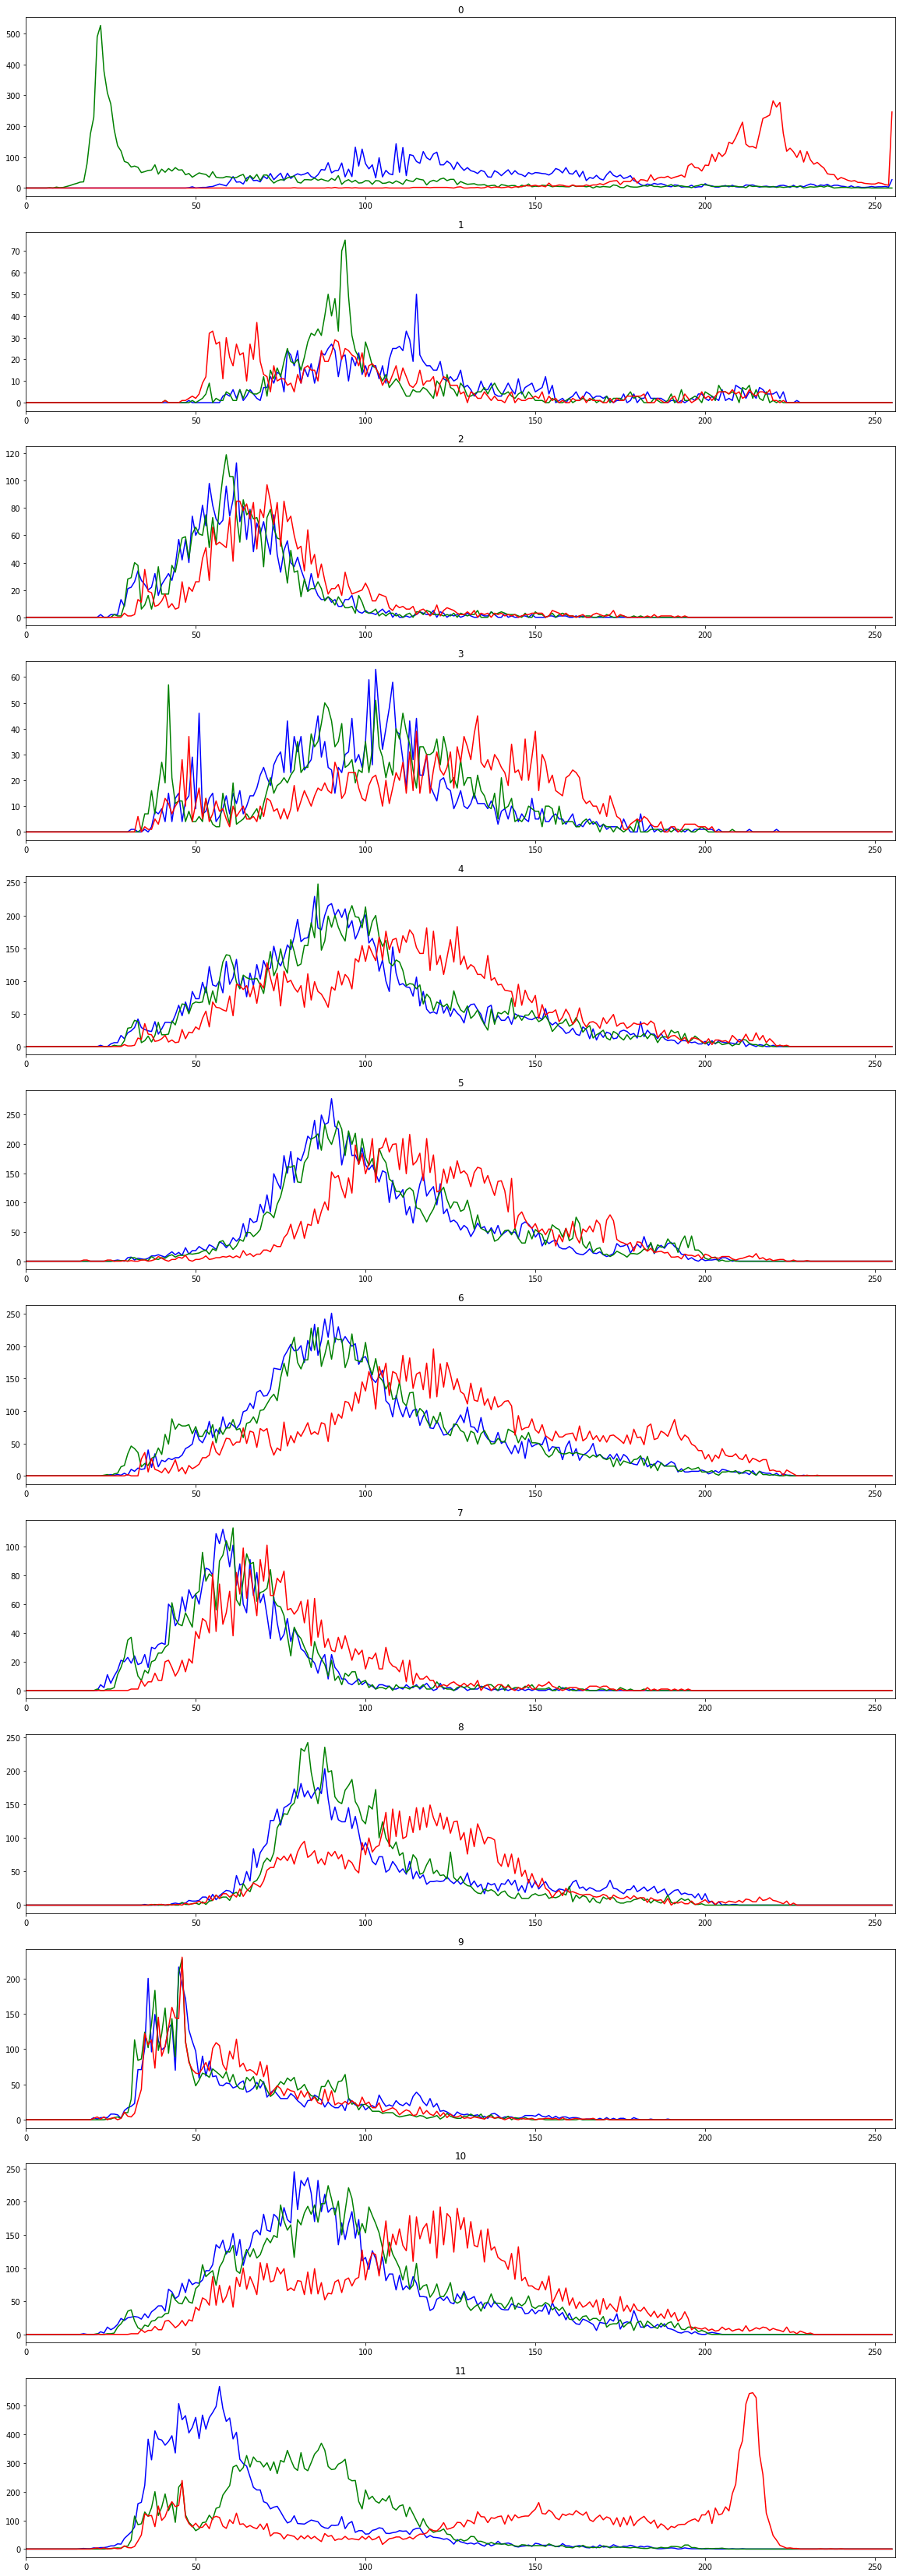

In [20]:
img_1 = cv2.imread(path, -1)

f = plt.figure(figsize=(20, len(moments) * 5))
for i, (M, cnt) in enumerate(moments):
    mask = np.full(img.shape[:2], 0, np.uint8)
    plt.subplot(len(moments), 1, i+1)
    color = ('b','g','r')
    cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
    plt.title(str(i))
    for j, col in enumerate(color):
        histr = cv2.calcHist([img_1],[j], mask, [256], [0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
plt.show()

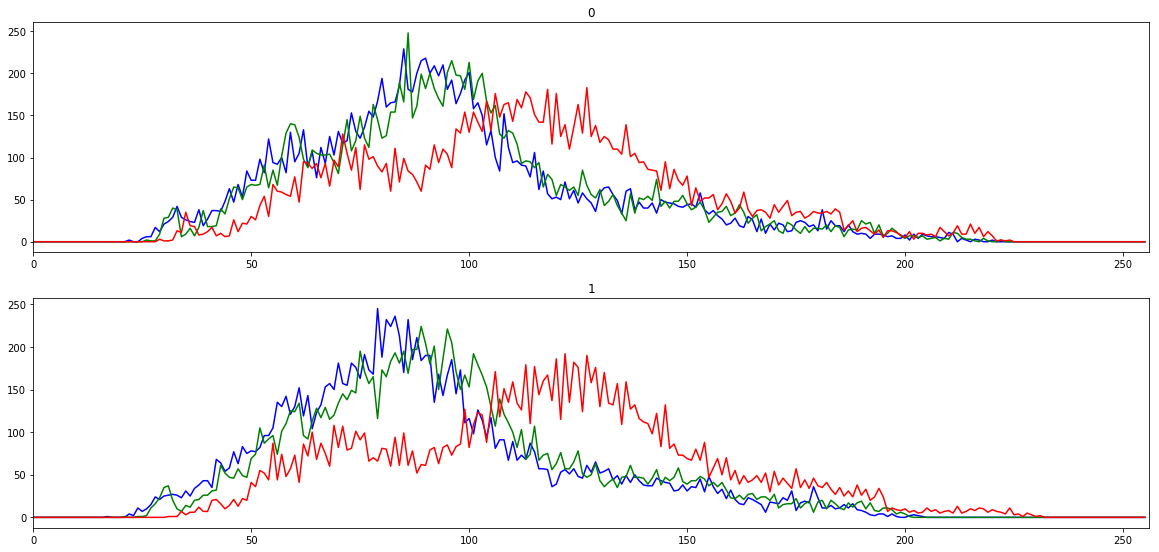

In [21]:
f = plt.figure(figsize=(20, len(moments) * 5))
for i, (M, cnt) in enumerate((moments[4], moments[10])):
    mask = np.full(img.shape[:2], 0, np.uint8)
    plt.subplot(len(moments), 1, i+1)
    color = ('b','g','r')
    cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
    plt.title(str(i))
    for j, col in enumerate(color):
        histr = cv2.calcHist([img_1],[j], mask, [256], [0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
plt.show()

# TODO

We had found some areas of interest, the contours in those areas, and histograms of these area. We still need to look into the moments and figure out how to use that and histograms to discard false positives.